In [1]:
%load_ext autoreload
%autoreload 2 
%reload_ext autoreload
%matplotlib inline
import matplotlib.pyplot as plt

# To access the contents of the parent dir
import sys; sys.path.insert(0, '../')
import os
from scipy.io import loadmat
from utils import *
from models import AutoEncoder, ae_loss
from preprocess import *

# Let's do facy optimizers
from optimizers import Lookahead, AdamGC, SGDGC
from madgrad import MADGRAD
from lbfgsnew import LBFGSNew

# Tracking
from tqdm import trange

import sympy
import sympytorch

You can use npar for np.array


In [2]:
noise_intensity = 0.01

# Loading the KS sol
DATA_PATH = "../deephpms_data/KS_simple3.pkl"
data = pickle_load(DATA_PATH)
t = data['t']
x = data['x']
X, T = np.meshgrid(x, t)
Exact = data['u'].T
if noise_intensity > 0.0:
    Exact = perturb(Exact, intensity=noise_intensity, noise_type="normal")
    print("Perturbed Exact with intensity =", float(noise_intensity))

x_star = X.flatten()[:,None]
t_star = T.flatten()[:,None]
X_star = np.hstack((x_star, t_star))
u_star = Exact.T.flatten()[:,None]

# Doman bounds
lb = X_star.min(axis=0)
ub = X_star.max(axis=0)

N = 2000
print(f"Fine-tuning with {N} samples")
idx = np.random.choice(X_star.shape[0], N, replace=False)
X_u_train = X_star[idx, :]
u_train = u_star[idx,:]

# Convert to torch.tensor
X_u_train = to_tensor(X_u_train, True)
u_train = to_tensor(u_train, False)
X_star = to_tensor(X_star, True)
u_star = to_tensor(u_star, False)

# lb and ub are used in adversarial training
scaling_factor = 1.0
lb = scaling_factor*to_tensor(lb, False)
ub = scaling_factor*to_tensor(ub, False)

# Feature names, base on the symbolic regression results
feature_names=('uf', 'u_x', 'u_xx', 'u_xxxx'); feature2index = {}

Loaded from ../deephpms_data/KS_simple3.pkl
Perturbed Exact with intensity = 0.01
Fine-tuning with 2000 samples


In [3]:
program = '''
-0.534833*u_xx-0.518928*u_xxxx-0.541081*uf*u_x
'''
pde_expr, variables = build_exp(program); print(pde_expr, variables)
mod = sympytorch.SymPyModule(expressions=[pde_expr]); mod.train()

-0.541081*u_x*uf - 0.534833*u_xx - 0.518928*u_xxxx {uf, u_xxxx, u_xx, u_x}


SymPyModule(expressions=(-0.541081*u_x*uf - 0.534833*u_xx - 0.518928*u_xxxx,))

In [4]:
class PINN(nn.Module):
    def __init__(self, model, loss_fn, index2features, scale=False, lb=None, ub=None, pretrained=False):
        super(PINN, self).__init__()
        self.model = model
        if not pretrained: self.model.apply(self.xavier_init)
        self.callable_loss_fn = loss_fn
        self.index2features = index2features; self.feature2index = {}
        for idx, fn in enumerate(self.index2features): self.feature2index[fn] = str(idx)
        self.scale = scale; self.lb, self.ub = lb, ub
        self.diff_flag = diff_flag(self.index2features)
        
    def xavier_init(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    def forward(self, x, t):
        H = torch.cat([x, t], dim=1)
        if self.scale: H = self.neural_net_scale(H)
        return self.model(H)
    
    def loss(self, x, t, y_input, update_network_params=True, update_pde_params=True):
        total_loss = []
        grads_dict, u_t = self.grads_dict(x, t)
        # MSE Loss
        if update_network_params:
            mse_loss = F.mse_loss(grads_dict["uf"], y_input)
            total_loss.append(mse_loss)
        # PDE Loss
        if update_pde_params:
            l_eq = F.mse_loss(self.callable_loss_fn(**grads_dict).squeeze(-1), u_t)
            total_loss.append(l_eq)
            
        return total_loss
    
    def grads_dict(self, x, t):
        uf = self.forward(x, t)
        u_t = self.gradients(uf, t)[0]
        
        ### PDE Loss calculation ###
        derivatives = group_diff(uf, (x, t), self.diff_flag[1], function_notation="u", gd_init={"uf":uf})
        
### Old and slow implementation ###
#         for t in self.diff_flag[0]:
#             if t=='uf': derivatives['X'+self.feature2index[t]] = uf
#             elif t=='x': derivatives['X'+self.feature2index[t]] = x
#         for t in self.diff_flag[1]:
#             out = uf
#             for c in t:
#                 if c=='x': out = self.gradients(out, x)[0]
#                 elif c=='t': out = self.gradients(out, t)[0]
#             derivatives['X'+self.feature2index['u_'+t[::-1]]] = out
        
        return derivatives, u_t
    
    def gradients(self, func, x):
        return grad(func, x, create_graph=True, retain_graph=True, grad_outputs=torch.ones(func.shape))
    
    def neural_net_scale(self, inp): 
        return -1.0+2.0*(inp-self.lb)/(self.ub-self.lb)

In [5]:
model = TorchMLP(dimensions=[2, 50, 50, 50 ,50, 50, 1], activation_function=nn.Tanh, bn=nn.LayerNorm, dropout=None)

# Pretrained model
semisup_model_state_dict = torch.load("./saved_path_inverse_small_KS/simple3_semisup_model_state_dict_250labeledsamples250unlabeledsamples.pth")
parameters = OrderedDict()
# Filter only the parts that I care about renaming (to be similar to what defined in TorchMLP).
inner_part = "network.model."
for p in semisup_model_state_dict:
    if inner_part in p:
        parameters[p.replace(inner_part, "")] = semisup_model_state_dict[p]
model.load_state_dict(parameters)

pinn = PINN(model=model, loss_fn=mod, index2features=feature_names, scale=True, lb=lb, ub=ub, pretrained=True)

Using old implementation of TorchMLP. See models.py for more new model-related source code.


In [6]:
pinn = load_weights(pinn, "./saved_path_inverse_small_KS/final_finetuned_pinn_5000.pth")

Loaded the model's weights properly


100%|██████████| 10000/10000 [00:07<00:00, 1275.06it/s]


tensor(1.6345e-05, grad_fn=<MseLossBackward>)


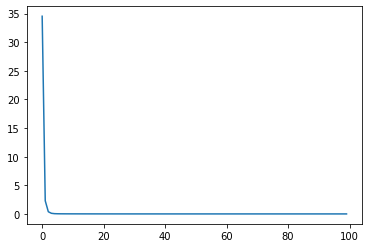

In [7]:
ae = AutoEncoder()
opt = torch.optim.Adam(ae.parameters(), lr=1e-3)
hist = []
for i in trange(10000):
    opt.zero_grad()
    recon_X = ae(X_u_train)
    loss = ae_loss(recon_X, X_u_train, include_l1=0.0)
    loss.backward()
    opt.step()
    if i%100==0: hist.append(loss.item())
ae.eval()
recon_X = ae(X_u_train); print(F.mse_loss(recon_X, X_u_train))
plt.plot(hist); plt.show()

In [8]:
def closure():
    if torch.is_grad_enabled(): optimizer2.zero_grad()
    denoised_X = ae(X_u_train)
    losses = pinn.loss(denoised_X[:, 0:1], denoised_X[:, 1:2], u_train, update_network_params=True, update_pde_params=True)
    l = sum(losses)+0.1*ae_loss(denoised_X, X_u_train)
    if l.requires_grad: l.backward(retain_graph=True)
    return l

def mtl_closure():
    n_obj = 3 # There are two tasks
    denoised_X = ae(X_u_train)
    losses = pinn.loss(denoised_X[:, 0:1], denoised_X[:, 1:2], u_train, update_network_params=True, update_pde_params=True)
    losses.append(0.1*ae_loss(denoised_X, X_u_train))
    
    updated_grads = []
    for i in range(n_obj):
        optimizer1.zero_grad()
        losses[i].backward(retain_graph=True)

        g_task = []
        for param in list(ae.parameters()) + list(pinn.parameters()):
            if param.grad is not None:
                g_task.append(Variable(param.grad.clone(), requires_grad=False))
            else:
                g_task.append(Variable(torch.zeros(param.shape), requires_grad=False))
        # appending the gradients from each task
        updated_grads.append(g_task)

    updated_grads = list(pcgrad.pc_grad_update(updated_grads))[0]
    for idx, param in enumerate(list(ae.parameters()) + list(pinn.parameters())): 
        param.grad = (updated_grads[0][idx]+updated_grads[1][idx])
        
    return sum(losses)

In [9]:
epochs1, epochs2 = 200, 200
# TODO: Save best state dict and training for more epochs.
optimizer1 = MADGRAD([{'params':ae.parameters()}, {'params':pinn.parameters()}], lr=1e-7)
optimizer1.param_groups[0]['lr'] = 1e-6
optimizer1.param_groups[1]['lr'] = 1e-7
ae.train(); pinn.train(); best_train_loss = 1e6

print('1st Phase optimization using Adam with PCGrad gradient modification')
for i in range(epochs1):
    optimizer1.step(mtl_closure)
    l = mtl_closure()
    if (i % 10) == 0 or i == epochs1-1:
        print("Epoch {}: ".format(i), l.item())

1st Phase optimization using Adam with PCGrad gradient modification
Epoch 0:  9.064186451723799e-05
Epoch 10:  9.357862290926278e-05


KeyboardInterrupt: 

In [ ]:
optimizer2 = torch.optim.LBFGS(list(ae.parameters()) + list(pinn.parameters()), lr=1e-1, max_iter=500, max_eval=int(500*1.25), history_size=300, line_search_fn='strong_wolfe')
ae.train(); pinn.train()

print('2nd Phase optimization using LBFGS')
for i in range(epochs2):
    optimizer2.step(closure)
    if (i % 10) == 0 or i == epochs2-1:
        l = closure()
        print("Epoch {}: ".format(i), l.item())

In [ ]:
ae.eval(); pinn.eval()
pred_params = [x.item() for x in pinn.callable_loss_fn.parameters()]
print(pred_params)

In [ ]:
errs = 100*(np.array(pred_params)+1)
errs.mean(), errs.std()

In [ ]:
# save(pinn, "./saved_path_inverse_small_KS/noisy_final_finetuned_pinn_5000.pth")
# save(ae, "./saved_path_inverse_small_KS/ae_5000.pth")